In [38]:
# import libraries
import time
import copy
import glob
import random
import os

import opendatasets as od
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18, resnet34

import multiprocess as mp

from dataset import XrayDataset

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
dataset_url = 'https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia'
od.download(dataset_url)

Skipping, found downloaded files in "./chest-xray-pneumonia" (use force=True to force download)


In [4]:
data_dir = '/Users/hayleyso/CNN_pneumonia_project/data/chest-xray-pneumonia/chest_xray'
files = os.listdir(data_dir)
print(files[:5])

['test', 'train', '.ipynb_checkpoints', 'val']


In [5]:
# train paths
train_normal = glob.glob(os.path.join(data_dir, 'train', 'NORMAL', '*'))
train_pneumonia = glob.glob(os.path.join(data_dir, 'train', 'PNEUMONIA', '*'))

# test paths
test_normal = glob.glob(os.path.join(data_dir, 'test', 'NORMAL', '*'))
test_pneumonia = glob.glob(os.path.join(data_dir, 'test', 'PNEUMONIA', '*'))

In [7]:
# combine file paths for trainset
train_paths = train_normal + train_pneumonia

# combine file paths for testset
test_paths = test_normal + test_pneumonia

In [8]:
train_labels = [0]*len(train_normal)+[1]*len(train_pneumonia)
test_labels = [0]*len(test_normal)+[1]*len(test_pneumonia)

In [9]:
print(len(train_paths), len(train_labels))
print(len(test_paths), len(test_labels))

5216 5216
624 624


In [10]:
# split data to train & validation sets
train_paths, valid_paths, train_labels, valid_labels = train_test_split(train_paths,
                                                                        train_labels,
                                                                        stratify=train_labels) # ensures a balanced distribution of target classes between the training + validation sets

In [11]:
# display random X-ray images (normal + abnormal)
def show_random_images():
    path_random_normal = random.choice(train_normal)
    path_random_abnormal = random.choice(train_pneumonia)
    
    fig = plt.figure(figsize=(10, 5))
    
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(Image.open(path_random_normal).convert("LA"))
    ax1.set_title("Normal X-ray")
    
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.imshow(Image.open(path_random_abnormal).convert("LA"))
    ax2.set_title("Abnormal X-ray")

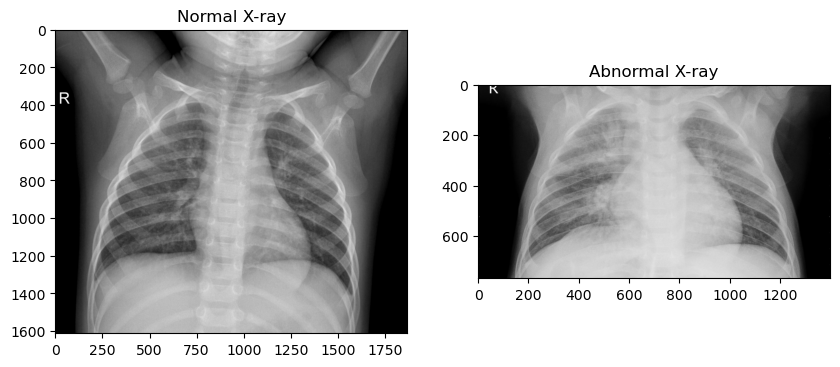

In [12]:
show_random_images()
plt.show()

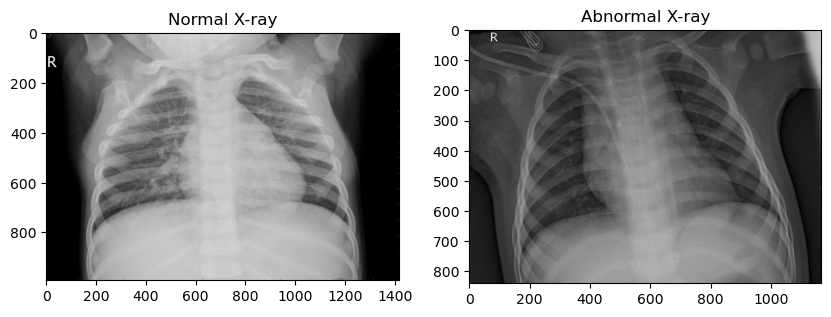

In [13]:
show_random_images()

In [14]:
train_dataset = XrayDataset(train_paths, train_labels)

In [15]:
next(iter(train_dataset))

(<PIL.Image.Image image mode=RGB size=1558x1380>, tensor([0.]))

In [39]:
# model
class PneumoniaNet(nn.Module):
    def __init__(self, pretrained=True):
        super(PneumoniaNet, self).__init__()
        
        # use the weights parameter with 'imagenet' value
        self.backbone = resnet18(weights='DEFAULT') if pretrained else resnet18(weights=None)
        
        # fully connected layer for binary classification (output 1 for pneumonia, 0 for normal)
        self.fc = nn.Linear(in_features=512, out_features=1)
        
    def forward(self, x):
        # backbone layers
        
        # convolution layer #1
        x = self.backbone.conv1(x)
        
        # batch normalization 1
        x = self.backbone.bn1(x)
        
        # ReLU activation function
        x = self.backbone.relu(x)
        
        # max pooling layer 
        x = self.backbone.maxpool(x)
        
        #residual layers
        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
        
        # global average pooling layer
        x = self.backbone.avgpool(x)
        x = x.view(x.size(0), 512)
        
        # fully connected layer
        x = self.fc(x)
        
        return x

In [18]:
# define train augmentation & validation pipeline
image_size = (500, 500)

train_transform = transforms.Compose([
    # transfor pillow image to tensor
    transforms.ToTensor(),
    
    # applies a random rotation to the image, the degree of rotation is sampled uniformly from the range [-15, 15].
    transforms.RandomRotation(degrees=15),
    
    # standardizes + resizes input size of images
    transforms.Resize(size=image_size, antialias=True),
    
    # normalize the image using pre-defined mean and standard deviation values
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=image_size, antialias=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = XrayDataset(train_paths, train_labels, train_transform)
valid_dataset = XrayDataset(valid_paths, valid_labels, test_transform)

In [19]:
dataset = XrayDataset(train_paths, train_labels, train_transform)

# check the type of the instance
print(type(dataset))

<class 'dataset.XrayDataset'>


In [20]:
pretrained = True
model = PneumoniaNet(pretrained=pretrained)
lr = 0.01

num_epochs = 5
train_batch_size = 16
valid_batch_size = 16

# load data + divide into mini-batches
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, num_workers=5, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=valid_batch_size, num_workers=5, shuffle=False)

# combine dataloaders for easy access
dataloaders = {
    "train": train_loader,
    "val": valid_loader
}

# log steps for printing progress during training & validation (every 10% of the dataset)
logging_steps = {
    "train":len(dataloaders["train"])//10,
    "val":len(dataloaders["val"]) // 10    
}

dataset_sizes = {
    "train":len(train_dataset),
    "val": len(valid_dataset)
}

batch_sizes = {
    "train":train_batch_size,
    "val":valid_batch_size
}

# loss function for training 
criterion = nn.BCEWithLogitsLoss()
# updates model's parameters during training
optimizer = Adam(model.parameters(),lr=lr)

In [21]:
print(type(train_loader.dataset))
print(type(valid_loader.dataset))

<class 'dataset.XrayDataset'>
<class 'dataset.XrayDataset'>


In [22]:
def train_model(model, criterion, optimizer, num_epochs, device=device):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0

    for epoch in tqdm(range(num_epochs), leave=False):
        for phase in ["train", "val"]:
            
            # set model to train mode or evaluation mode during validation
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for i, (inputs, labels) in tqdm(enumerate(dataloaders[phase]), total=len(dataloaders[phase]), leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the gradient
                optimizer.zero_grad()
                
                # FORWARD PASS
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)

                    # apply sigmoid function + threshold at 0.5 for binary classification
                    preds = outputs.sigmoid() > 0.5
                    loss = criterion(outputs, labels.float())
                    
                    # BACKWARD PASS & OPTIMIZATION
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # accumulate batch loss weighted by the # of inputs
                running_loss += loss.item() * inputs.size(0)
                
                
                # update correct predictions count for the current batch
                running_corrects += torch.sum(preds == labels.data)
                
                # log training progress
                if ( i % logging_steps[phase])== 0 & (i > 0):
                    avg_loss = running_loss / ((i + 1) * batch_sizes[phase])
                    avg_acc = running_corrects / ((i + 1) * batch_sizes[phase])

                    print(f"[{phase}]: {epoch + 1} / {num_epochs} | loss: {avg_loss} | acc: {avg_acc}")

            # calculate epoch-level loss + accuracy
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

            # update weights if validation accuracy improves
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    # total training time
    time_elapsed = time.time() - since
    print(f"training took {time_elapsed} seconds")
    
    # load the best model's weights before returning the trained model
    model.load_state_dict(best_model_wts)
    return model

In [23]:
model = train_model(model, criterion, optimizer, num_epochs)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

[train]: 1 / 5 | loss: 0.7356340885162354 | acc: 0.3125
[train]: 1 / 5 | loss: 0.7112529182434082 | acc: 0.7124999761581421
[train]: 1 / 5 | loss: 0.6100237217484689 | acc: 0.7321428656578064
[train]: 1 / 5 | loss: 0.5808434425151512 | acc: 0.7200342416763306
[train]: 1 / 5 | loss: 0.5617321371724925 | acc: 0.7235824465751648
[train]: 1 / 5 | loss: 0.5535392459512742 | acc: 0.7169421315193176
[train]: 1 / 5 | loss: 0.5200007522928304 | acc: 0.7379310131072998
[train]: 1 / 5 | loss: 0.507142949827324 | acc: 0.7466716170310974
[train]: 1 / 5 | loss: 0.4908804619404936 | acc: 0.7571243643760681
[train]: 1 / 5 | loss: 0.4752643227165196 | acc: 0.7652649879455566
[train]: 1 / 5 | loss: 0.45880779432310603 | acc: 0.7748962640762329
train Loss: 0.4553 Acc: 0.7763


  0%|          | 0/82 [00:00<?, ?it/s]

[val]: 1 / 5 | loss: 0.6350792646408081 | acc: 0.625
[val]: 1 / 5 | loss: 0.40787167350451153 | acc: 0.8125
[val]: 1 / 5 | loss: 0.3468127180548275 | acc: 0.841911792755127
[val]: 1 / 5 | loss: 0.34342567205429075 | acc: 0.8349999785423279
[val]: 1 / 5 | loss: 0.3188436704151558 | acc: 0.8560606241226196
[val]: 1 / 5 | loss: 0.3094922471337202 | acc: 0.8612805008888245
[val]: 1 / 5 | loss: 0.31673024868478583 | acc: 0.8545918464660645
[val]: 1 / 5 | loss: 0.32379518658445594 | acc: 0.8497806787490845
[val]: 1 / 5 | loss: 0.32476556301116943 | acc: 0.8480769395828247
[val]: 1 / 5 | loss: 0.3273567316466815 | acc: 0.8433219194412231
[val]: 1 / 5 | loss: 0.32733109409426464 | acc: 0.841821014881134
val Loss: 0.3260 Acc: 0.8428



  0%|          | 0/245 [00:00<?, ?it/s]

[train]: 2 / 5 | loss: 0.23255202174186707 | acc: 0.9375
[train]: 2 / 5 | loss: 0.32832360148429873 | acc: 0.8525000214576721
[train]: 2 / 5 | loss: 0.2945397207323386 | acc: 0.8647959232330322
[train]: 2 / 5 | loss: 0.290205519493312 | acc: 0.8715753555297852
[train]: 2 / 5 | loss: 0.27074120201400875 | acc: 0.8788659572601318
[train]: 2 / 5 | loss: 0.2900835450523156 | acc: 0.875
[train]: 2 / 5 | loss: 0.2994030766446015 | acc: 0.8689655065536499
[train]: 2 / 5 | loss: 0.298034741196054 | acc: 0.8716716170310974
[train]: 2 / 5 | loss: 0.2998415593231589 | acc: 0.8701424598693848
[train]: 2 / 5 | loss: 0.2937551689621765 | acc: 0.8718317747116089
[train]: 2 / 5 | loss: 0.28623651159749486 | acc: 0.8747406601905823
train Loss: 0.2867 Acc: 0.8745


  0%|          | 0/82 [00:00<?, ?it/s]

[val]: 2 / 5 | loss: 0.9491726160049438 | acc: 0.625
[val]: 2 / 5 | loss: 0.4473386936717563 | acc: 0.7986111044883728
[val]: 2 / 5 | loss: 0.38031693131608124 | acc: 0.8345588445663452
[val]: 2 / 5 | loss: 0.3863880263268948 | acc: 0.8224999904632568
[val]: 2 / 5 | loss: 0.350947837373524 | acc: 0.8390151262283325
[val]: 2 / 5 | loss: 0.3452763810935544 | acc: 0.8429877758026123
[val]: 2 / 5 | loss: 0.3474410522196974 | acc: 0.8431122303009033
[val]: 2 / 5 | loss: 0.3551038573577739 | acc: 0.8377193212509155
[val]: 2 / 5 | loss: 0.3612824319073787 | acc: 0.8336538672447205
[val]: 2 / 5 | loss: 0.3602070486402675 | acc: 0.8339040875434875
[val]: 2 / 5 | loss: 0.3633435777400011 | acc: 0.8333333134651184
val Loss: 0.3613 Acc: 0.8344



  0%|          | 0/245 [00:00<?, ?it/s]

[train]: 3 / 5 | loss: 0.11782358586788177 | acc: 0.9375
[train]: 3 / 5 | loss: 0.3336685746908188 | acc: 0.8500000238418579
[train]: 3 / 5 | loss: 0.3290030500110315 | acc: 0.8673469424247742
[train]: 3 / 5 | loss: 0.30089487574280127 | acc: 0.880993127822876
[train]: 3 / 5 | loss: 0.2941651681495696 | acc: 0.8865979313850403
[train]: 3 / 5 | loss: 0.28148098677889377 | acc: 0.889979362487793
[train]: 3 / 5 | loss: 0.279433689883043 | acc: 0.8883620500564575
[train]: 3 / 5 | loss: 0.2818124540061993 | acc: 0.8853550553321838
[train]: 3 / 5 | loss: 0.27763140948556864 | acc: 0.8856865167617798
[train]: 3 / 5 | loss: 0.2681168265606401 | acc: 0.8911290168762207
[train]: 3 / 5 | loss: 0.2614563194207878 | acc: 0.8936722278594971
train Loss: 0.2626 Acc: 0.8934


  0%|          | 0/82 [00:00<?, ?it/s]

[val]: 3 / 5 | loss: 0.7654106020927429 | acc: 0.5
[val]: 3 / 5 | loss: 0.6460781759685941 | acc: 0.6458333134651184
[val]: 3 / 5 | loss: 0.6456244219751919 | acc: 0.6433823704719543
[val]: 3 / 5 | loss: 0.6217196547985077 | acc: 0.6600000262260437
[val]: 3 / 5 | loss: 0.6203822963165514 | acc: 0.6685606241226196
[val]: 3 / 5 | loss: 0.6116071881317511 | acc: 0.6783536672592163
[val]: 3 / 5 | loss: 0.6095898911661032 | acc: 0.6823979616165161
[val]: 3 / 5 | loss: 0.618288799336082 | acc: 0.6853070259094238
[val]: 3 / 5 | loss: 0.6228186423961933 | acc: 0.682692289352417
[val]: 3 / 5 | loss: 0.6094678027989113 | acc: 0.6900684833526611
[val]: 3 / 5 | loss: 0.61358223653134 | acc: 0.6859567761421204
val Loss: 0.6119 Acc: 0.6863



  0%|          | 0/245 [00:00<?, ?it/s]

[train]: 4 / 5 | loss: 0.08083851635456085 | acc: 1.0
[train]: 4 / 5 | loss: 0.20113924771547317 | acc: 0.9100000262260437
[train]: 4 / 5 | loss: 0.18547920202266197 | acc: 0.9170918464660645
[train]: 4 / 5 | loss: 0.19116718350105907 | acc: 0.9152397513389587
[train]: 4 / 5 | loss: 0.19037269979484917 | acc: 0.9162371158599854
[train]: 4 / 5 | loss: 0.2024104993728813 | acc: 0.91425621509552
[train]: 4 / 5 | loss: 0.21187273866400635 | acc: 0.9129310250282288
[train]: 4 / 5 | loss: 0.23307617097960773 | acc: 0.9053254723548889
[train]: 4 / 5 | loss: 0.2359519892039231 | acc: 0.9041450619697571
[train]: 4 / 5 | loss: 0.2280045997797756 | acc: 0.9063940048217773
[train]: 4 / 5 | loss: 0.22608519780654382 | acc: 0.9084543585777283
train Loss: 0.2240 Acc: 0.9095


  0%|          | 0/82 [00:00<?, ?it/s]

[val]: 4 / 5 | loss: 1.4352707862854004 | acc: 0.625
[val]: 4 / 5 | loss: 0.7751204205883874 | acc: 0.6805555820465088
[val]: 4 / 5 | loss: 0.780071332174189 | acc: 0.6764705777168274
[val]: 4 / 5 | loss: 0.8021190237998962 | acc: 0.6924999952316284
[val]: 4 / 5 | loss: 0.7419848044713339 | acc: 0.7140151262283325
[val]: 4 / 5 | loss: 0.7155446588266187 | acc: 0.7225610017776489
[val]: 4 / 5 | loss: 0.7051277218424544 | acc: 0.7283163070678711
[val]: 4 / 5 | loss: 0.692057718049016 | acc: 0.7302631735801697
[val]: 4 / 5 | loss: 0.7236336703483875 | acc: 0.7288461327552795
[val]: 4 / 5 | loss: 0.7027844333485381 | acc: 0.7380136847496033
[val]: 4 / 5 | loss: 0.7148266169759963 | acc: 0.7391975522041321
val Loss: 0.7125 Acc: 0.7400



  0%|          | 0/245 [00:00<?, ?it/s]

[train]: 5 / 5 | loss: 0.4417049288749695 | acc: 0.8125
[train]: 5 / 5 | loss: 0.1911120480298996 | acc: 0.9100000262260437
[train]: 5 / 5 | loss: 0.17700676357715714 | acc: 0.9196428656578064
[train]: 5 / 5 | loss: 0.19088026791913051 | acc: 0.920376718044281
[train]: 5 / 5 | loss: 0.19214537515084154 | acc: 0.9226804375648499
[train]: 5 / 5 | loss: 0.19807675159112972 | acc: 0.9209710955619812
[train]: 5 / 5 | loss: 0.19649911416244917 | acc: 0.9228448271751404
[train]: 5 / 5 | loss: 0.19536319801572866 | acc: 0.9238165616989136
[train]: 5 / 5 | loss: 0.19218229453219343 | acc: 0.9242228269577026
[train]: 5 / 5 | loss: 0.1836325426860648 | acc: 0.9282833933830261
[train]: 5 / 5 | loss: 0.17896220218815312 | acc: 0.9307572841644287
train Loss: 0.1793 Acc: 0.9305


  0%|          | 0/82 [00:00<?, ?it/s]

[val]: 5 / 5 | loss: 0.06550713628530502 | acc: 1.0
[val]: 5 / 5 | loss: 0.31111411936581135 | acc: 0.9513888955116272
[val]: 5 / 5 | loss: 0.3294727992718382 | acc: 0.9301470518112183
[val]: 5 / 5 | loss: 0.2969429145613685 | acc: 0.9300000071525574
[val]: 5 / 5 | loss: 0.27856454754047183 | acc: 0.9242424368858337
[val]: 5 / 5 | loss: 0.25433349373633973 | acc: 0.9298780560493469
[val]: 5 / 5 | loss: 0.3090861433664365 | acc: 0.9196428656578064
[val]: 5 / 5 | loss: 0.3130846229466618 | acc: 0.9177631735801697
[val]: 5 / 5 | loss: 0.32107093363167505 | acc: 0.9173076748847961
[val]: 5 / 5 | loss: 0.32105852138172924 | acc: 0.9152397513389587
[val]: 5 / 5 | loss: 0.32280073347350546 | acc: 0.915123462677002
val Loss: 0.3208 Acc: 0.9156

training took 35966.18273091316 seconds


In [26]:
# combine test set paths for NORMAL + PNEUMONIA
test_paths = glob.glob(os.path.join(data_dir, "test", "NORMAL", '*')) + glob.glob(os.path.join(data_dir, "test", "PNEUMONIA", '*'))

# assign labels: 0 for NORMAL, 1 for PNEUMONIA
test_labels = [0] * len(glob.glob(os.path.join(data_dir, "test", "NORMAL", '*'))) + [1] * len(glob.glob(os.path.join(data_dir, "test", "PNEUMONIA", '*')))

In [27]:
len(test_paths), len(test_labels)

(624, 624)

In [28]:
test_dataset = XrayDataset(test_paths, test_labels, test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=False)

In [29]:
y_pred = []
y_true = []

for i, (tensors, labels) in tqdm(enumerate(test_dataloader), leave=False, total=len(test_dataloader)):
    with torch.no_grad():
        
        # get binary predictions using sigmoid threshold
        predictions = model(tensors)
        predictions = predictions.sigmoid()
        predictions = predictions > 0.5
        
        # collect true predictions
        y_pred.append(predictions)
        
        # collect true labels
        y_true.append(labels)

  0%|          | 0/20 [00:00<?, ?it/s]

In [30]:
# concatenate both lists into single tensors along dimension 0
y_pred = torch.cat(y_pred)
y_true = torch.cat(y_true)

In [31]:
# shape of tensors
y_pred.shape, y_true.shape

(torch.Size([624, 1]), torch.Size([624, 1]))

In [32]:
# convert tensors -> NumPy arrays
y_pred = y_pred.numpy()
y_true = y_true.numpy()

In [33]:
# convert labels to 64-bit integers 
y_pred = y_pred.astype(np.int64)
y_true = y_true.astype(np.int64)

In [34]:
# flatten to 1-dimension
y_pred = y_pred.reshape(-1)
y_true = y_true.reshape(-1)

In [35]:
y_pred.shape, y_true.shape

((624,), (624,))

In [37]:
# the model's accuracy
accuracy_score(y_true, y_pred)

0.7227564102564102